## Importing Relevant Libraries

In [37]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

## Data Retrieval

### Setting up Connection to BigQuery

In [38]:
client = bigquery.Client()

### Loading Data from BigQuery

In [39]:
# Define the query to retrieve data from the laps table
laps_query = """
    SELECT * FROM `strava-etl.strava_data.laps`
"""
laps_query_job = client.query(laps_query)

# Convert laps data to a dataframe
laps = laps_query_job.to_dataframe()
laps.head()

,id,resource_state,name,elapsed_time,moving_time,start_date,start_date_local,distance,average_speed,max_speed,...,max_heartrate,pace_zone,activity_id,activity_visibility,activity_resource_state,athlete_id,athlete_resource_state,start_day,start_hour,start_weekday
0,41582694580,2,Lap 4,398,398,2024-07-15 12:27:43+00:00,2024-07-15 08:27:43+00:00,1609.34,4.04,5.298,...,175.0,2,11893488406,None,<NA>,57248538,<NA>,15,8,0
1,41582694568,2,Lap 2,403,403,2024-07-15 12:14:16+00:00,2024-07-15 08:14:16+00:00,1609.34,3.99,4.946,...,166.0,2,11893488406,None,<NA>,57248538,<NA>,15,8,0
2,41582694590,2,Lap 5,404,404,2024-07-15 12:34:22+00:00,2024-07-15 08:34:22+00:00,1609.34,3.98,5.616,...,178.0,2,11893488406,None,<NA>,57248538,<NA>,15,8,0
3,41582694571,2,Lap 3,404,404,2024-07-15 12:20:59+00:00,2024-07-15 08:20:59+00:00,1609.34,3.98,4.826,...,169.0,2,11893488406,None,<NA>,57248538,<NA>,15,8,0
4,41582694609,2,Lap 8,411,411,2024-07-15 12:55:14+00:00,2024-07-15 08:55:14+00:00,1608.63,3.91,4.814,...,182.0,2,11893488406,None,<NA>,57248538,<NA>,15,8,0


## Data Exploration

In [40]:
laps.dtypes

id                                       Int64
resource_state                           Int64
name                                    object
elapsed_time                             Int64
moving_time                              Int64
start_date                 datetime64[us, UTC]
start_date_local           datetime64[us, UTC]
distance                               float64
average_speed                          float64
max_speed                              float64
lap_index                                Int64
split                                    Int64
start_index                              Int64
end_index                                Int64
total_elevation_gain                   float64
average_cadence                        float64
device_watts                             Int64
average_watts                          float64
average_heartrate                      float64
max_heartrate                          float64
pace_zone                                Int64
activity_id  

## Data Preprocessing

### Removing Duplicates

In [41]:
print(laps.shape)

(2184, 29)


In [42]:
laps = laps.drop_duplicates(subset='id', keep='first')

In [43]:
print(laps.shape)

(2184, 29)


### Drop Empty Columns

In [44]:
# Identify columns that are completely empty
empty_columns = laps.columns[laps.isna().all()]

# Drop columns that are completely empty
laps = laps.drop(columns=empty_columns)

# Print the names of dropped columns (optional)
print("Dropped columns:", empty_columns)

# Print the shape of the new dataframe
print(laps.shape)

# Print the new dataframe
laps.head(5)

Dropped columns: Index(['activity_visibility', 'activity_resource_state',
       'athlete_resource_state'],
      dtype='object')
(2184, 26)


,id,resource_state,name,elapsed_time,moving_time,start_date,start_date_local,distance,average_speed,max_speed,...,device_watts,average_watts,average_heartrate,max_heartrate,pace_zone,activity_id,athlete_id,start_day,start_hour,start_weekday
0,41582694580,2,Lap 4,398,398,2024-07-15 12:27:43+00:00,2024-07-15 08:27:43+00:00,1609.34,4.04,5.298,...,1,356.5,171.1,175.0,2,11893488406,57248538,15,8,0
1,41582694568,2,Lap 2,403,403,2024-07-15 12:14:16+00:00,2024-07-15 08:14:16+00:00,1609.34,3.99,4.946,...,1,339.0,162.4,166.0,2,11893488406,57248538,15,8,0
2,41582694590,2,Lap 5,404,404,2024-07-15 12:34:22+00:00,2024-07-15 08:34:22+00:00,1609.34,3.98,5.616,...,1,384.7,175.0,178.0,2,11893488406,57248538,15,8,0
3,41582694571,2,Lap 3,404,404,2024-07-15 12:20:59+00:00,2024-07-15 08:20:59+00:00,1609.34,3.98,4.826,...,1,344.9,166.9,169.0,2,11893488406,57248538,15,8,0
4,41582694609,2,Lap 8,411,411,2024-07-15 12:55:14+00:00,2024-07-15 08:55:14+00:00,1608.63,3.91,4.814,...,1,395.3,177.6,182.0,2,11893488406,57248538,15,8,0


### Checking for missing values

In [45]:
# Get the count of missing values in each column
missing_values = laps.isna().sum()

# Display columns with their respective missing values count
print(missing_values)

id                      0
resource_state          0
name                    0
elapsed_time            0
moving_time             0
start_date              0
start_date_local        0
distance                0
average_speed           0
max_speed               0
lap_index               0
split                   0
start_index             0
end_index               0
total_elevation_gain    0
average_cadence         0
device_watts            0
average_watts           0
average_heartrate       0
max_heartrate           0
pace_zone               0
activity_id             0
athlete_id              0
start_day               0
start_hour              0
start_weekday           0
dtype: int64


In [46]:
#laps.drop(['workout_type', 'prefer_perceived_exertion'], axis=1,inplace=True)
laps.drop(['activity_id', 'athlete_id'], axis=1,inplace=True)
print(laps.shape)

(2184, 24)


In [47]:
laps = laps.dropna()
print(laps.shape)

(2184, 24)


### Removing Demo activities

## Prediciting Grade Adjusted Pace from Laps Table

In [48]:
laps.columns.values

array(['id', 'resource_state', 'name', 'elapsed_time', 'moving_time',
       'start_date', 'start_date_local', 'distance', 'average_speed',
       'max_speed', 'lap_index', 'split', 'start_index', 'end_index',
       'total_elevation_gain', 'average_cadence', 'device_watts',
       'average_watts', 'average_heartrate', 'max_heartrate', 'pace_zone',
       'start_day', 'start_hour', 'start_weekday'], dtype=object)

In [49]:
# List of selected columns to keep as features
feature_columns = [
    'elapsed_time','distance', 'average_speed', 'max_speed', 'total_elevation_gain',
    'average_cadence',  'average_watts', 'average_heartrate','max_heartrate'
]

# Keep only the selected columns in your DataFrame
X = laps[feature_columns]
y = laps['moving_time']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Modeling

### Linear Regression Model

In [51]:
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print("Linear Regression MAE:", mae_lr)
print("Linear Regression R²:", r2_lr)

Linear Regression MAE: 12.370445224385502
Linear Regression R²: 0.9860121945060785


### Random Forest model

In [52]:
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])

param_grid_rf = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [10, 20, 30, None],
    'rf__min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
grid_search_rf.fit(X_train, y_train)

best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest MAE:", mae_rf)
print("Random Forest R²:", r2_rf)
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)

Random Forest MAE: 1.1227055153034704
Random Forest R²: 0.9989079581316219
Best Parameters for Random Forest: {'rf__max_depth': 10, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}


### XGBoost model

In [53]:
pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42))
])

param_grid_xgb = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 6, 10],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.7, 0.8, 0.9]
}

grid_search_xgb = GridSearchCV(estimator=pipeline_xgb, param_grid=param_grid_xgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
grid_search_xgb.fit(X_train, y_train)

best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print("XGBoost MAE:", mae_xgb)
print("XGBoost R²:", r2_xgb)
print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)

XGBoost MAE: 1.466601588360505
XGBoost R²: 0.999196469783783
Best Parameters for XGBoost: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 200, 'xgb__subsample': 0.8}


### Best performance model

In [54]:
model_performance = {
    "Linear Regression": {"MAE": mae_lr, "R²": r2_lr},
    "Random Forest": {"MAE": mae_rf, "R²": r2_rf},
    "XGBoost": {"MAE": mae_xgb, "R²": r2_xgb}
}

best_model_mae = min(model_performance, key=lambda x: model_performance[x]["MAE"])
best_model_r2 = max(model_performance, key=lambda x: model_performance[x]["R²"])

print("Best Model based on MAE:")
print(f"{best_model_mae} with MAE = {model_performance[best_model_mae]['MAE']} and R² = {model_performance[best_model_mae]['R²']}")

print("\nBest Model based on R²:")
print(f"{best_model_r2} with R² = {model_performance[best_model_r2]['R²']} and MAE = {model_performance[best_model_r2]['MAE']}")

Best Model based on MAE:
Random Forest with MAE = 1.1227055153034704 and R² = 0.9989079581316219

Best Model based on R²:
XGBoost with R² = 0.999196469783783 and MAE = 1.466601588360505


### Grade Adjusted Pace Calculation

In [55]:
# Select the best model
if best_model_mae == best_model_r2:
    final_model = best_model_mae
else:
    final_model = best_model_mae 

# Retrieve the trained model
if final_model == "Linear Regression":
    selected_model = lr_model
elif final_model == "Random Forest":
    selected_model = best_rf
else:
    selected_model = best_xgb

In [56]:
# Copy X_test to start building the prediction dataframe
pred_df = X_test.copy()
pred_df['total_elevation_gain'] = 0  

# Make predictions for moving time
predicted_moving_time = selected_model.predict(pred_df)
pred_df['orig_total_elevation_gain'] = X_test['total_elevation_gain']
pred_df['orig_moving_time'] = y_test
pred_df['pred_moving_time'] = predicted_moving_time


pred_df['distance_miles'] = pred_df['distance'] * 0.000621371
pred_df['orig_moving_time_mins'] = pred_df['orig_moving_time'] / 60.0  
pred_df['pred_moving_time_mins'] = pred_df['pred_moving_time'] / 60.0  


pred_df['pace'] = pred_df['orig_moving_time_mins'] / pred_df['distance_miles']

# Calculate Grade Adjusted Pace (GAP)
grade_percent = (pred_df['orig_total_elevation_gain'] / pred_df['distance']) * 100
adjustment_factor = 0.03  
pred_df['Grade_Adjusted_Pace'] = (pred_df['pred_moving_time_mins'] + grade_percent * adjustment_factor * pred_df['distance_miles']) / pred_df['distance_miles']
pred_df['diff'] = pred_df['Grade_Adjusted_Pace']-pred_df['pace']


pred_df[['orig_total_elevation_gain', 'orig_moving_time_mins', 'pred_moving_time_mins', 'Grade_Adjusted_Pace', 'pace', 'diff']].head(5)

,orig_total_elevation_gain,orig_moving_time_mins,pred_moving_time_mins,Grade_Adjusted_Pace,pace,diff
282,3.2,5.416667,5.414917,5.422042,5.417826,0.004216
367,4.6,5.366667,5.476367,5.486116,5.367816,0.1183
514,11.8,6.816667,6.823076,6.845091,6.816686,0.028406
605,24.0,6.883333,6.882946,6.929168,6.884807,0.04436
508,26.4,6.933333,6.932357,6.981589,6.933353,0.048236


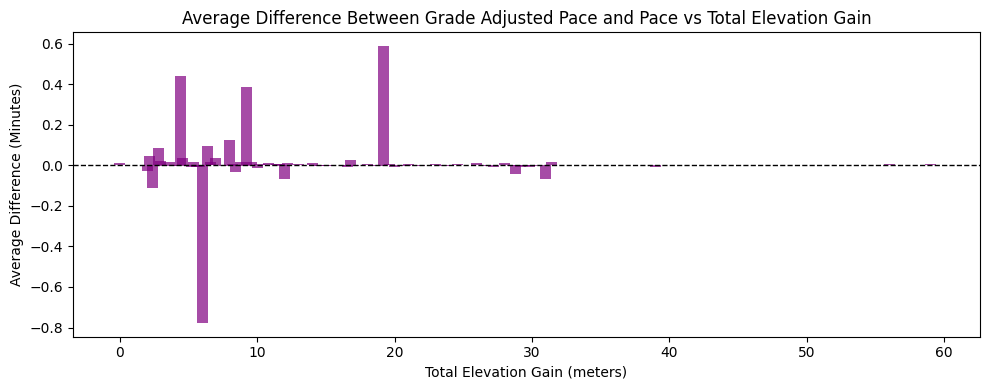

In [69]:
import matplotlib.pyplot as plt

# Calculate the difference between GAP and Pace
pred_df['gap_vs_pace_diff'] = pred_df['Grade_Adjusted_Pace'] - pred_df['pace']

# Group by total_elevation_gain and calculate the mean difference
avg_diff_df = pred_df.groupby('orig_total_elevation_gain').agg(
    avg_diff=('gap_vs_pace_diff', 'mean')
).reset_index()

# Set up the figure
plt.figure(figsize=(10, 4))

# Plot the average difference between GAP and Pace
plt.bar(avg_diff_df['orig_total_elevation_gain'], avg_diff_df['avg_diff'], color='purple', alpha=0.7)

# Add labels and title
plt.title('Average Difference Between Grade Adjusted Pace and Pace vs Total Elevation Gain')
plt.xlabel('Total Elevation Gain (meters)')
plt.ylabel('Average Difference (Minutes)')
plt.axhline(0, color='black', linewidth=1, linestyle='--')  # Horizontal line at 0 for reference

# Show the plot
plt.tight_layout()
plt.show()

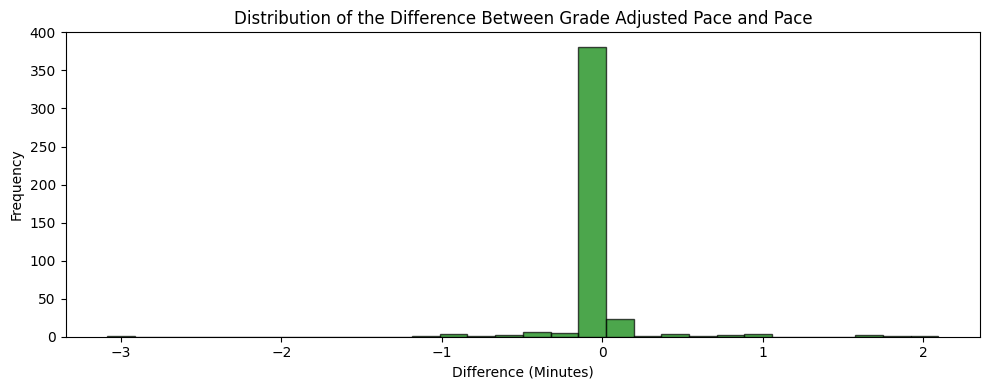

In [68]:
# Plot histogram of the difference between GAP and Pace
plt.figure(figsize=(10, 4))
plt.hist(pred_df['gap_vs_pace_diff'], bins=30, color='green', edgecolor='black', alpha=0.7)

# Add labels and title
plt.title('Distribution of the Difference Between Grade Adjusted Pace and Pace')
plt.xlabel('Difference (Minutes)')
plt.ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()

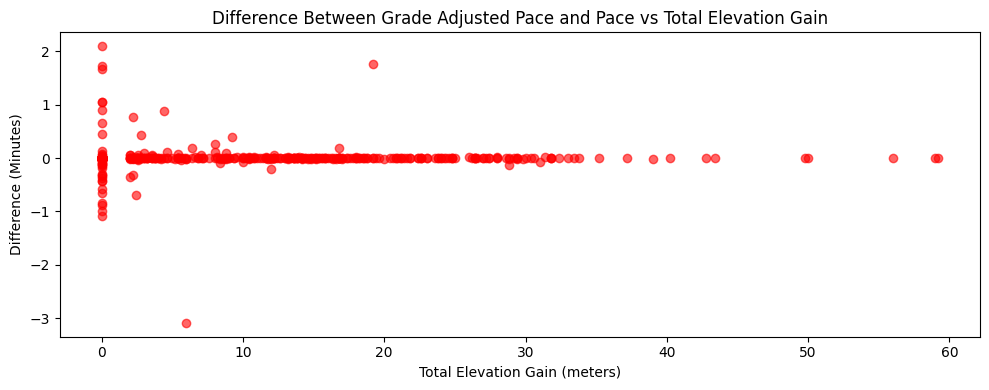

In [67]:
# Set up the figure
plt.figure(figsize=(10, 4))

# Plot the difference between GAP and Pace
plt.scatter(pred_df['orig_total_elevation_gain'], pred_df['gap_vs_pace_diff'], color='red', alpha=0.6)

# Add labels and title
plt.title('Difference Between Grade Adjusted Pace and Pace vs Total Elevation Gain')
plt.xlabel('Total Elevation Gain (meters)')
plt.ylabel('Difference (Minutes)')

# Show the plot
plt.tight_layout()
plt.show()

In [57]:
# Copy X_test to start building the prediction dataframe
pred_df = X_test.copy()
pred_df['total_elevation_gain'] = 0  

# Make predictions for moving time
predicted_moving_time = selected_model.predict(pred_df)
pred_df['orig_total_elevation_gain'] = X_test['total_elevation_gain']
pred_df['orig_moving_time'] = y_test
pred_df['pred_moving_time'] = predicted_moving_time


pred_df['distance_miles'] = pred_df['distance'] * 0.000621371
pred_df['orig_moving_time_mins'] = pred_df['orig_moving_time'] / 60.0  
pred_df['pred_moving_time_mins'] = pred_df['pred_moving_time'] / 60.0  


pred_df['pace'] = pred_df['orig_moving_time_mins'] / pred_df['distance_miles']

pred_df['Grade_Adjusted_Pace'] = pred_df['pred_moving_time_mins'] / pred_df['distance_miles']
pred_df['diff'] = pred_df['Grade_Adjusted_Pace']-pred_df['pace']

#pred_df[['orig_total_elevation_gain', 'orig_moving_time_mins', 'pred_moving_time_mins', 'Grade_Adjusted_Pace', 'pace', 'diff']].head(5)